In [1]:
import os
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('../../')

In [3]:
processed_data = pd.read_csv('data/processed/data.csv')

In [5]:
X, y = processed_data.drop('ILG', axis=1), processed_data['ILG']

In [6]:
reg = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', LinearRegression())
])

In [9]:
params = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'estimator__fit_intercept': [True, False],
    'estimator__copy_X': [True, False],
    'estimator__n_jobs': [1, -1],
    'estimator__positive': [True, False],
}

2025/03/19 11:42:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best score:  140.871159829432
Best params:  {'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__n_jobs': 1, 'estimator__positive': True, 'scaler': StandardScaler()}


/var/folders/z2/x55d_0sd3zl143hy_l05bnpr0000gn/T/ipykernel_1593/2620975039.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df, y=X.columns, palette='plasma')


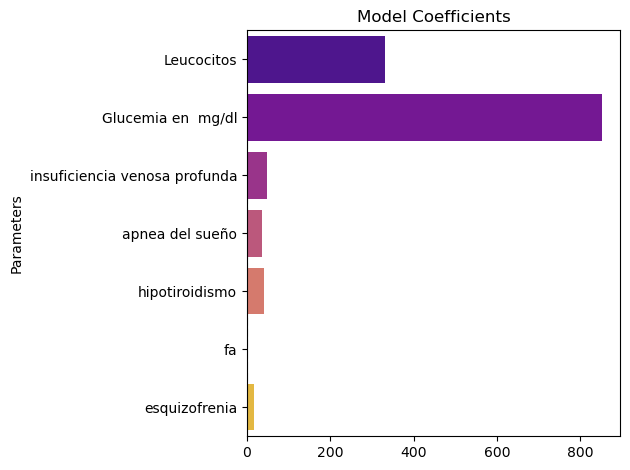

In [10]:
with mlflow.start_run():

    grid = GridSearchCV(estimator=reg, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid.fit(X, y)

    mlflow.log_param('model_type', 'regression')
    for param, value in grid.best_params_.items():
        mlflow.log_param(param, value)
    
    mlflow.log_metric('best_score', np.sqrt(-grid.best_score_))
    mlflow.sklearn.log_model(grid.best_estimator_, 'LinearRegression')

    print('Best score: ', np.sqrt(-grid.best_score_))
    print('Best params: ', grid.best_params_)

    coef_df = grid.best_estimator_.named_steps['estimator'].coef_

    sns.barplot(x=coef_df, y=X.columns, palette='plasma')
    plt.title('Model Coefficients')
    plt.ylabel('Parameters')
    plt.axvline(0, color='grey', linestyle='--')
    plt.tight_layout()

    mlflow.log_figure(plt.gcf(), 'linear_regression_coefficients.png')

    plt.show()